In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# The usual notebook preferences

%config InlineBackend.figure_format = 'svg'

import numpy
import sys
import matplotlib.pyplot as plt

sys.path.append('..')
from helper_functions import *

HTML(toggle_code("import functions"))

<IPython.core.display.HTML object>

In [3]:
set_notebook_preferences()

## Overfitting and regularisation in classification

We have previously encountered the [binary logistic classification](classification_logistic_regression_model.ipynb) and [multi-class softmax classification](classification_multiclass.ipynb) models. Both models were decribed as linear in the sense that their class probability contours were straight lines. Consequently, in any decision problem, the decision boundaries will also be straight lines. This is a severe assumption that is not typically appropriate. In this section we will consider data where non-linear models are required. We will focus on non-linear binary logistic classification, but it will be straight forward to use the same approach for non-linear multi-class softmax classification. As a running example we will use the synthetic crescent dataset shown below.

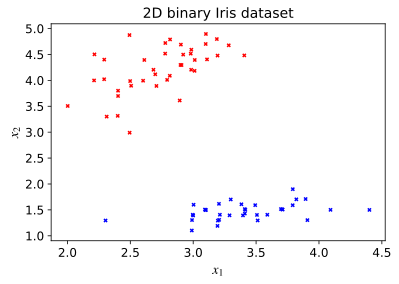

<IPython.core.display.HTML object>

In [10]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

x = x[np.where(np.logical_not(y == 2))[0]] 
y = y[np.where(np.logical_not(y == 2))[0]] # removing the datapoints of class 2

x = x[:,1:3] 

no_train = (x.shape[0]*3)//4
x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:]

class_0, class_1 = np.where(y_train == 0), np.where(y_train == 1)
plt.scatter(x_train[class_0, 0], x_train[class_0, 1], color = 'blue', marker = 'x', s = 10)
plt.scatter(x_train[class_1, 0], x_train[class_1, 1], color = 'red', marker = 'x', s = 10)
beautify_plot({"title":r"2D binary Iris dataset", "x":"$x_1$", "y":"$x_2$"})
plt.show()


HTML(toggle_code())

In [11]:
def sig(x):
    
    return 1/(1 + np.exp(-x)) # define logistic function for convenience

def gradient_ascent(x, y, init_weights, no_steps, stepsize): # x: train inputs, y: train labels, rest self explanatory
    
    x = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = 1) # add 1's to the inputs as usual
    
    w = init_weights.copy() # copy weights (to prevent changing init_weights as a side-effect - don't dwell on this)
    
    w_history, log_liks = [], [] # arrays for storing weights and log-liklihoods at each step
    
    for n in range(no_steps): # in this part we optimise log-lik w.r.t. w
        
        log_liks.append(np.sum(y * np.log(sig(x.dot(w))) + (1 - y) * np.log(1 - sig(x.dot(w))))) # record current log-lik
        
        w_history.append(w.copy()) # record current weights (use w.copy() to prevent aliasing - don't dwell on this)
    
        sigs = sig(x.dot(w)) # using our neat convenience function
        
        dL_dw = np.mean((y - sigs)*x.T, axis = 1) # calculate gradient of log-likelihood w.r.t. w
        
        w += stepsize * dL_dw # update weights and repeat
    
    return np.array(w_history), np.array(log_liks) 

HTML(toggle_code("gradient ascent function"))

<IPython.core.display.HTML object>

Second, we have to select appropriate basis functions. Here we use isotropic Gaussian basis functions $\phi_{d}(\mathbf{x}) = \exp(-\frac{1}{2*l^2} | \mathbf{x} - \mu_{d}|^2)$. These are also called **radial basis functions**. The means $\mu_d$ are arranged in a 7 x 7 grid across the input space and have a length-scale equal to 0.3. These basis functions are shown on the right subplot below. On the right hand side you can see the log-likelihood plotted as a function of the number of iterations of gradient ascent.

(10000, 3)


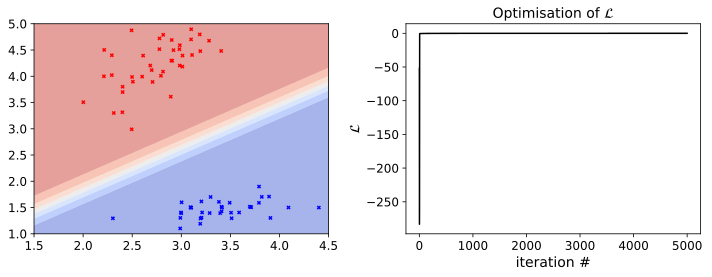

Final log-likelihood = -0.01 nats


<IPython.core.display.HTML object>

In [18]:
w_history, log_liks = gradient_ascent(x_train, y_train, np.zeros(shape = (2 + 1,)), 5000, 2)
0
x1 = np.linspace(1.5, 4.5, 100)
x2 = np.linspace(1, 5, 100)

test_grid = np.stack(np.meshgrid(x1, x2), axis = 2).reshape((-1, 2))

test_grid = np.append(np.ones(shape = (test_grid.shape[0], 1)), test_grid, axis = 1)

pred = sig(test_grid.dot(w_history[-1])).reshape(100, 100)


print(test_grid.shape)


fig=plt.figure(figsize=(10, 4), dpi= 80)


plt.subplot(1,2,1)
plt.contourf(x1, x2,pred, cmap = 'coolwarm', alpha = 0.5, origin = 'lower')
plt.scatter(x_train[class_0, 0], x_train[class_0, 1], color = 'blue', marker = 'x', s = 10)
plt.scatter(x_train[class_1, 0], x_train[class_1, 1], color = 'red', marker = 'x', s = 10)

plt.subplot(1,2,2)
plt.plot(log_liks, color = 'black')
beautify_plot({"title":r"Optimisation of $\mathcal{L}$", "x":"iteration #", "y":"$\mathcal{L}$"})


fig.tight_layout()
plt.show()

x = np.arange(10)

print("Final log-likelihood = {0:.2f} nats".format(log_liks[-1]))
HTML(toggle_code())

In [ ]:
#x = np.load('class_1d_inputs.npy')
#y = np.load('class_1d_labels.npy')
#x_train, x_test, y_train, y_test = x[:20], x[20:], y[:20], y[20:]




lengthscale = 0.3
no_x, no_y = 7, 7

mu1 = np.linspace(-1.1, 1.1, no_x)
mu2 = np.linspace(-1.1, 1.1, no_y)

rbf_grid = np.stack(np.meshgrid(mu1, mu2), axis = 2)
rbf_grid = np.stack([rbf_grid]*x_train.shape[0], axis = 0)

points = np.stack([x_train]*no_x*no_y, axis = 1).reshape((x_train.shape[0], no_x, no_y, 2))
phi = np.exp(-np.sum((rbf_grid - points)**2, axis = -1)/(2*lengthscale**2)).reshape((x_train.shape[0], -1))

w_history, log_liks = gradient_ascent(phi, y_train, np.zeros(shape = (no_x*no_y + 1,)), 500, 1)


fig=plt.figure(figsize=(10, 4), dpi= 80)


plt.subplot(1,2,1)

theta = np.linspace(0,2*np.pi,50)                  
x_circ = lengthscale*np.cos(theta)    
y_circ = lengthscale*np.sin(theta)                        
                    
for a in range(no_x):
    for b in range(no_y):
        xs = mu1[a] + x_circ
        ys = mu2[b] + y_circ
        plt.plot(xs,ys,color = 'gray')
                    
plt.scatter(x_train[class_0, 0], x_train[class_0, 1], color = 'blue', marker = 'x', s = 10)
plt.scatter(x_train[class_1, 0], x_train[class_1, 1], color = 'red', marker = 'x', s = 10)



beautify_plot({"title":r"Basis functions", "x":"$x_1$", "y":"$x_2$"})


plt.subplot(1,2,2)
plt.plot(log_liks, color = 'black')
beautify_plot({"title":r"Optimisation of $\mathcal{L}$", "x":"iteration #", "y":"$\mathcal{L}$"})


fig.tight_layout()
plt.show()

x = np.arange(10)

print("Final log-likelihood = {0:.2f} nats".format(log_liks[-1]))
HTML(toggle_code())

Now lets try and visualise the predictions of the trained model as probability contours in the input space $\mathbf{x}$. In the  figure below input points that have a strong red colour correspond to confident predictions of class 1, points that are  a strong blue colour correspond to confident predictions of class 0, and points that are not strongly coloured are close to 50:50. The probability contours are clearly non-linear and the model appears to be making reasonable predictions.

In [ ]:
test_grid = np.stack(np.meshgrid(np.linspace(-1.1, 1.1, 100), np.linspace(-1.1, 1.1, 100)), axis = 2).reshape((-1, 2))
rbf_grid = np.stack(np.meshgrid(np.linspace(-1.1, 1.1, no_x), np.linspace(-1.1, 1.1, no_y)), axis = 2)
rbf_grid = np.stack([rbf_grid]*test_grid.shape[0], axis = 0)

points = np.stack([test_grid]*no_x*no_y, axis = 1).reshape((test_grid.shape[0], no_x, no_y, 2))
phi_ = np.exp(-np.sum((rbf_grid - points)**2, axis = -1)/(2*lengthscale**2)).reshape((test_grid.shape[0], -1))
phi_pred = np.append(np.ones(shape = (phi_.shape[0], 1)), phi_, axis = -1)


pred = sig(phi_pred.dot(w_history[-1])).reshape(100, 100)
plt.contourf(np.linspace(-1.1, 1.1, 100), np.linspace(-1.1, 1.1, 100),
             pred, cmap = 'coolwarm', alpha = 0.5, origin = 'lower')
plt.scatter(x_train[class_0, 0], x_train[class_0, 1], color = 'blue', marker = 'x', s = 10)
plt.scatter(x_train[class_1, 0], x_train[class_1, 1], color = 'red', marker = 'x', s = 10)
beautify_plot({"title":r"Crescent dataset descision boundaries", "x":"$x_1$", "y":"$x_2$"})
plt.show()

(HTML(toggle_code()))

Finally, lets see how the model performs on the test set.

In [ ]:
def test_accuracy(test_x, test_y, w):
    x_ = np.append(np.ones(shape = (test_x.shape[0], 1)), test_x, axis = 1)
    y_ = sig(x_.dot(w))
    return 1 - abs((y_.round() - test_y)).mean()

rbf_grid = np.stack(np.meshgrid(np.linspace(-1.1, 1.1, no_x), np.linspace(-1.1, 1.1, no_y)), axis = 2)
rbf_grid = np.stack([rbf_grid]*x_test.shape[0], axis = 0)

points = np.stack([x_test]*no_x*no_y, axis = 1).reshape((x_test.shape[0], no_x, no_y, 2))
phi = np.exp(-np.sum((rbf_grid - points)**2, axis = -1)/(2*lengthscale**2)).reshape((x_test.shape[0], -1))

print("Classification accuracy for non-linear dataset = {}%".format(test_accuracy(phi, y_test, w_history[-1])*100))

HTML(toggle_code())

### Summary

Logistic and softmax classification can be turned into non-linear classifiers simply by changing the representation of the input. Instead of passing the inputs $\mathbf{x}_n$ directly to the algorithm, we can pass non-linear functions of the input $\boldsymbol{\Phi}(\mathbf{x}_n)$. These functions are called basis functions or features.

The basis functions need careful design (e.g. see question 1 below). Moreover, the naive method of tiling the space, as used in the examples above, does not scale to high dimensional input spaces where an exponential number of functions would be required. However, strategies such as centering radial basis functions at a randomly selected subset of the datapoints can sidestep the curse of dimensionality and work reasonably well.


In [section 3.5](classification_bayesian.ipynb) we will look at a Bayesian approach to logistic regression.

### Questions

**1. Effect of the number and length-scale of the basis functions**

Experiment with the code above to investigate the effect of using large and short length-scales in the basis functions, and small or large numbers of basis functions. See how these choices alter the final log-likelihood and the predictive probability contours.

<details>
<summary>Answer</summary>
<div>
    
Using very narrow radial basis functions with short length-scales results in probability contours that are less smooth and requires more basis functions for sensible predictions. Using broader radial basis function results in smoother contours and fewer basis functions are required, but the predictions might be overly simplistic.<br><br>

One useful rule of thumb for setting the width of radial basis functions is called the **median trick**. The median trick begins by computing the pairwise distances between the datapoints' inputs. It then sets the length-scale to be the median distance value.

</div>
</details>

**2. Overfitting**

Can you make the model above overfit? Change the length-scale and number of the basis functions, and increase the number of iterations of gradient ascent.

<details>
<summary>Answer</summary>
<div>
When large numbers of narrow basis functions are used (e.g. D = 40 x 40, l = 0.02) and many iterations of gradient ascent applied (e.g. tens of thousands) the model starts to overfit. Such a simulation can take a long time to run, but the log-likelihood asymptotes close to 0, whilst the test set accuracy is around 90% which is less than it was for the original setting (D = 7 x 7, l = 0.3, 500 iterations scores 100% accuracy on the test set). <br><br>

This is a classic example of overfitting: the model complexity grows with the number of basis functions and as the length-scale gets shorter. At somepoint the model can perfectly capture the training data, but makes poor predictions on the test data. One approach to preventing overfitting is to regularise the weights. Another, arguably less principled, approach is to use early stopping: that is, terminate gradient ascent before the model starts to overfit. 


</div>
</details>
